In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sqlalchemy import create_engine, Column, Integer, String, LargeBinary
from sqlalchemy.orm import sessionmaker, declarative_base
import os
from sqlalchemy.orm import declarative_base

In [24]:
train_kelias = r"C:\Users\Vartotojas\Desktop\POMIDORAI\pomidoru_duomenys\trenyravimas"
val_kelias = r"C:\Users\Vartotojas\Desktop\POMIDORAI\pomidoru_duomenys\validacija"
test_kelias = r"C:\Users\Vartotojas\Desktop\POMIDORAI\pomidoru_duomenys\testas"

In [25]:

Bazine_klase = declarative_base()
rysys_su_baze = create_engine('sqlite:///pomidoru_lapai.db')

Session = sessionmaker(bind=rysys_su_baze)
sesija = Session()

In [26]:
class PomidoraiTrenyravimas(Bazine_klase):

    __tablename__ = 'Pomidoru_lapai_trenyravimo_duomenys'

    id = Column(Integer,primary_key = True)
    kelias = Column(String, unique=True, nullable=False)  
    klases_pavadinimas = Column(String, nullable=False)


In [27]:
def irasyti_trenyravimo_paveikslelius(sesija, trenyravimo_kelias):

    for klases_pavadinimas in os.listdir(trenyravimo_kelias):
        klases_kelias = os.path.join(trenyravimo_kelias,klases_pavadinimas)

        if os.path.isdir(klases_kelias):
            for paveikslelio_pavadinimas in os.listdir(klases_kelias):
                paveikslelio_kelias = os.path.join(klases_kelias,paveikslelio_pavadinimas)

                egzistuoja = sesija.query(PomidoraiTrenyravimas).filter_by(kelias=paveikslelio_kelias).first()

                if not egzistuoja:

                    naujas_irasas = PomidoraiTrenyravimas(kelias = paveikslelio_kelias, klases_pavadinimas = klases_pavadinimas)

                    sesija.add(naujas_irasas)

    sesija.commit()

    print("Irasyti trenyravimo paveiksleiai")

In [28]:
class PomidoraiValidacija(Bazine_klase):

    __tablename__ = 'Pomidoru_lapai_validacijos_duomenys'

    id = Column(Integer,primary_key = True)
    kelias = Column(String, unique=True, nullable=False)  
    klases_pavadinimas = Column(String, nullable=False)

def irasyti_validacijos_paveikslelius(sesija, validacijos_kelias):

    for klases_pavadinimas in os.listdir(validacijos_kelias):
        klases_kelias = os.path.join(validacijos_kelias,klases_pavadinimas)

        if os.path.isdir(klases_kelias):
            for paveikslelio_pavadinimas in os.listdir(klases_kelias):
                paveikslelio_kelias = os.path.join(klases_kelias,paveikslelio_pavadinimas)

                egzistuoja = sesija.query(PomidoraiValidacija).filter_by(kelias=paveikslelio_kelias).first()

                if not egzistuoja:

                    naujas_irasas = PomidoraiValidacija(kelias = paveikslelio_kelias, klases_pavadinimas = klases_pavadinimas)

                    sesija.add(naujas_irasas)

    sesija.commit()

    print("Irasyti validacijos paveiksleiai")

In [29]:
class PomidoraiTestas(Bazine_klase):

    __tablename__ = 'Pomidoru_lapai_testo_duomenys'

    id = Column(Integer,primary_key = True)
    kelias = Column(String, unique=True, nullable=False)  
    klases_pavadinimas = Column(String, nullable=False)

def irasyti_testo_paveikslelius(sesija, testo_kelias):

    for klases_pavadinimas in os.listdir(test_kelias):
        klases_kelias = os.path.join(test_kelias,klases_pavadinimas)

        if os.path.isdir(klases_kelias):
            for paveikslelio_pavadinimas in os.listdir(klases_kelias):
                paveikslelio_kelias = os.path.join(klases_kelias,paveikslelio_pavadinimas)

                egzistuoja = sesija.query(PomidoraiTestas).filter_by(kelias=paveikslelio_kelias).first()

                if not egzistuoja:

                    naujas_irasas = PomidoraiTestas(kelias = paveikslelio_kelias, klases_pavadinimas = klases_pavadinimas)

                    sesija.add(naujas_irasas)

    sesija.commit()

    print("Irasyti testo paveiksleiai")

In [30]:
Bazine_klase.metadata.create_all(rysys_su_baze)

irasyti_trenyravimo_paveikslelius(sesija,train_kelias)
irasyti_validacijos_paveikslelius(sesija,val_kelias)
irasyti_testo_paveikslelius(sesija,test_kelias)

Irasyti trenyravimo paveiksleiai
Irasyti validacijos paveiksleiai
Irasyti testo paveiksleiai


In [31]:

train_df = pd.read_sql_table('Pomidoru_lapai_trenyravimo_duomenys', con=rysys_su_baze)

val_df = pd.read_sql_table('Pomidoru_lapai_validacijos_duomenys', con=rysys_su_baze)

test_df = pd.read_sql_table('Pomidoru_lapai_testo_duomenys', con=rysys_su_baze)


# print(train_df.head())
# print(val_df.head())
# print(test_df.head())

In [32]:
def issitraukti_paveikslelius(df, dydis=(128,128)):
    paveiksleliai = []
    klasifikacijos = []

    for indeksas, eilute in df.iterrows():
        paveikslelis = load_img(eilute['kelias'], target_size=dydis)
        paveikslelis_array = img_to_array(paveikslelis)
        paveiksleliai.append(paveikslelis_array)
        klasifikacijos.append(eilute['klases_pavadinimas'])

    return np.array(paveiksleliai), np.array(klasifikacijos)

x_train, y_train = issitraukti_paveikslelius(train_df)
x_val, y_val = issitraukti_paveikslelius(val_df)
x_test, y_test = issitraukti_paveikslelius(test_df)

x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [33]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [34]:
def uzkoduoti_klases_lable_onehot(y_train, y_val, y_test):

    enkoderis = LabelEncoder()
    y_train_skaiciais = enkoderis.fit_transform(y_train)
    y_val_skaiciais = enkoderis.transform(y_val)
    y_test_skaiciais = enkoderis.transform(y_test)

    print("Klases uzkoduotos")

    y_train_kategorijos = to_categorical(y_train_skaiciais)
    y_val_kategorijos = to_categorical(y_val_skaiciais)
    y_test_kategorijos = to_categorical(y_test_skaiciais)

    print("Paversta i kategorinius")

    return y_train_kategorijos, y_val_kategorijos, y_test_kategorijos


y_train, y_val, y_test = uzkoduoti_klases_lable_onehot(y_train,y_val,y_test)

Klases uzkoduotos
Paversta i kategorinius


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [36]:
def sukurti_paprasta_cnn(įvesties_forma, klasiu_skaicius, learning_rate=0.0001):
    modelis = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=įvesties_forma),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(klasiu_skaicius, activation='softmax')])

    optimizeris = keras.optimizers.Adam(learning_rate=learning_rate)

    modelis.compile(optimizer=optimizeris, loss='categorical_crossentropy',metrics=['accuracy'])

    return modelis

In [37]:
klasiu_skaicius = y_train.shape[1]

modelis = sukurti_paprasta_cnn((128, 128, 3), klasiu_skaicius)

c:\Users\Vartotojas\Desktop\POMIDORAI\pomidorai_repositorija\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

sustabdymas = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = modelis.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=40,batch_size=32,callbacks=[sustabdymas])

nuostolis, tikslumas = modelis.evaluate(x_test, y_test, verbose=1)

print(f"Testo loss: {nuostolis}")
print(f"Testo accuracy: {tikslumas}")

modelis.save("mano_modelis.h5")

Epoch 1/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 93s 656ms/step - accuracy: 0.9241 - loss: 0.2230 - val_accuracy: 0.9444 - val_loss: 0.1739
Epoch 2/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 605ms/step - accuracy: 0.9518 - loss: 0.1442 - val_accuracy: 0.9489 - val_loss: 0.1817
Epoch 3/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 593ms/step - accuracy: 0.9644 - loss: 0.1073 - val_accuracy: 0.9333 - val_loss: 0.2652
Epoch 4/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 600ms/step - accuracy: 0.9678 - loss: 0.0823 - val_accuracy: 0.9578 - val_loss: 0.1439
Epoch 5/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 99s 706ms/step - accuracy: 0.9808 - loss: 0.0593 - val_accuracy: 0.9589 - val_loss: 0.1502
Epoch 6/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 134s 644ms/step - accuracy: 0.9810 - loss: 0.0605 - val_accuracy: 0.9578 - val_loss: 0.1806
Epoch 7/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 601ms/step - accuracy: 0.9852 - loss: 0.0544 - val_accuracy: 0.9500 - val_loss: 0.2093
Epoch 8/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 623ms/step - accuracy: 0.9821 - loss:

In [41]:
import numpy as np

y_pradines = np.argmax(y_test, axis=1)

y_prognoze = modelis.predict(x_test)
y_prognoze = np.argmax(y_prognoze, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step


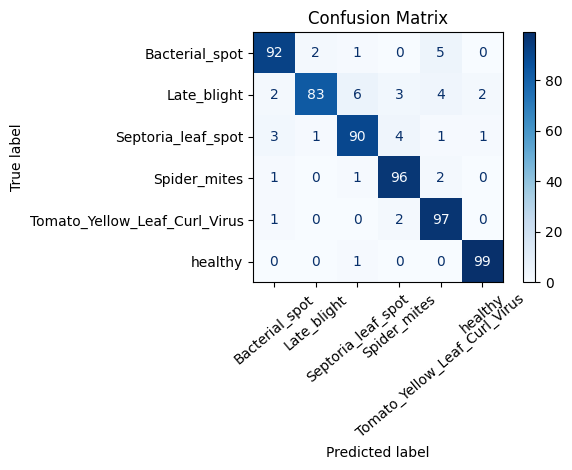

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

klasiu_pavadinimai = ['Bacterial_spot', 'Late_blight', 'Septoria_leaf_spot', 'Spider_mites', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy']

matrica = confusion_matrix(y_pradines, y_prognoze)
disp = ConfusionMatrixDisplay(confusion_matrix=matrica, display_labels=klasiu_pavadinimai)
disp.plot(xticks_rotation=40, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_pradines, y_prognoze, target_names=klasiu_pavadinimai, digits=4))

                               precision    recall  f1-score   support

               Bacterial_spot     0.9293    0.9200    0.9246       100
                  Late_blight     0.9651    0.8300    0.8925       100
           Septoria_leaf_spot     0.9091    0.9000    0.9045       100
                 Spider_mites     0.9143    0.9600    0.9366       100
Tomato_Yellow_Leaf_Curl_Virus     0.8899    0.9700    0.9282       100
                      healthy     0.9706    0.9900    0.9802       100

                     accuracy                         0.9283       600
                    macro avg     0.9297    0.9283    0.9278       600
                 weighted avg     0.9297    0.9283    0.9278       600

